# Lab Assignment Seven: RNNs

### Luis Garduno

Dataset : [Sentiment140 Kaggle Dataset](https://www.kaggle.com/kazanova/sentiment140) 

----------------------------

## 1. Preparation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Data Preparation

In [1]:
import glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tkinter import Tcl
from skimage.io import imshow
from sklearn import metrics as mt
from sklearn import preprocessing
%matplotlib inline

le = preprocessing.LabelEncoder()

# Load in Sentiment140 Dataset in pandas array
df = pd.read_csv('../data/Sentiment140/training.1600000.processed.noemoticon.csv',
                 names=['polarity', 'id', 'date', 'query', 'user', 'tweet'],
                 encoding='ISO-8859-1')

print("Number of Total Tweets:", len(df), "\n")

# Check if our dataset is missing any columns
df.info()

Number of Total Tweets: 1600000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   tweet     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


| Field | Description | Type |
| ----- | ----------- | ---- |
| **Polarity** | &nbsp;&nbsp;&nbsp; - The target/polarity of the tweet <br /> &nbsp;&nbsp; [0] Negative; [2] Neutral; [4] Positive; | Discrete |
| **id**    | &nbsp;&nbsp;&nbsp; - The id of the tweet    | Discrete |
| **date**  | &nbsp;&nbsp;&nbsp; - The date of the tweet  | Interval |
| **query** | &nbsp;&nbsp;&nbsp; - The query | Nominal |
| **user**  | &nbsp;&nbsp;&nbsp; - The user that tweeted  | nominal  |
| **tweet**  | &nbsp;&nbsp;&nbsp; - The text of the tweet  | nominal  |

polarity          2
id          1598315
date         774363
query             1
user         659775
tweet       1581466
dtype: int64

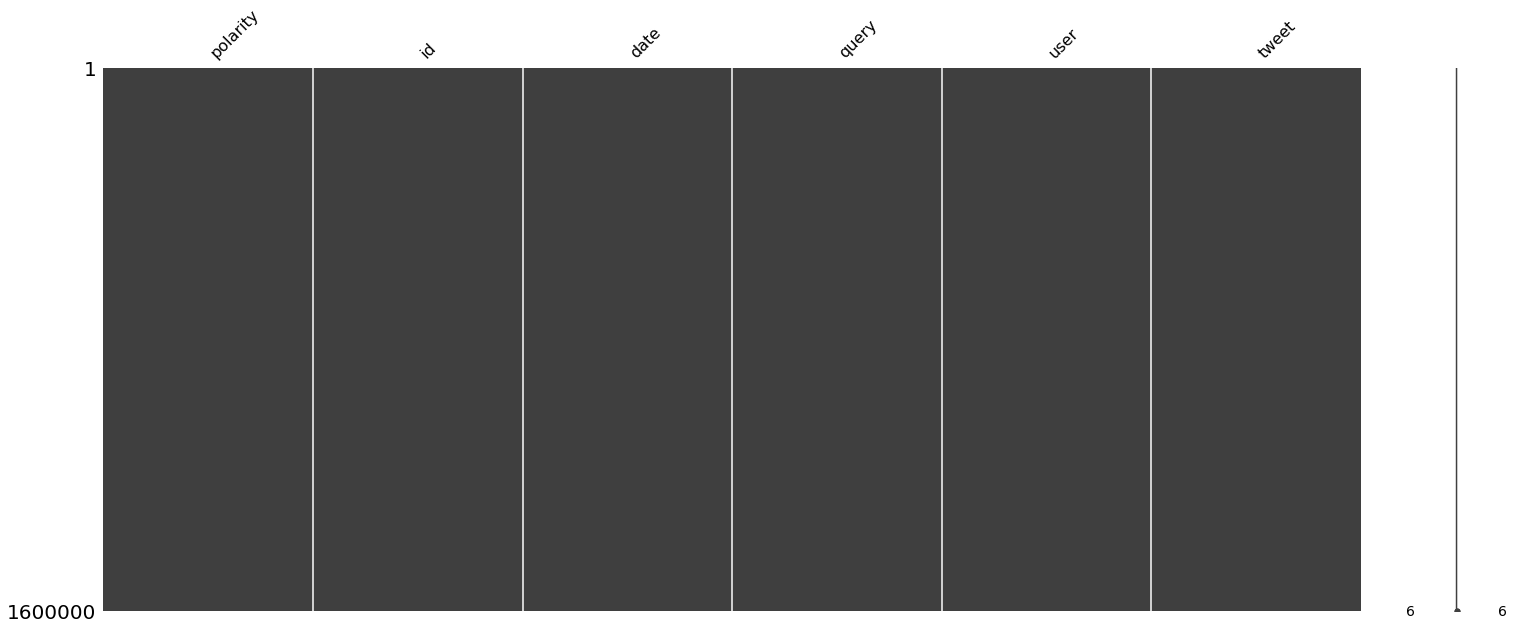

In [2]:
import missingno as mn

# Check for any missing/null values within dataset
mn.matrix(df)

# Find unique values within each field, before dropping columns.
df.nunique()

After outputting all of the unique values, we see that there is only 1 unique value
within the query field, meaning that it will not make an impact when further doing
our analysis because all the values are the same. Other fields that can be dropped
are the user tweet id, username, iand date because these these do not impact whether a
user's tweet is negative or positive.

Addtionally we're able to see that there's 2 unique values within the polarity field,
it is probably best to find out what these two values are and change them so that 0
equals negative and 1 equals positive.

In [3]:
# Drop the fields we don't need
df.drop(['id', 'date', 'query','user'], axis=1, inplace=True)

# Find the 2 unique polarity fields
df['polarity'].unique()

array([0, 4])

Text(0, 0.5, 'Number of Tweets')

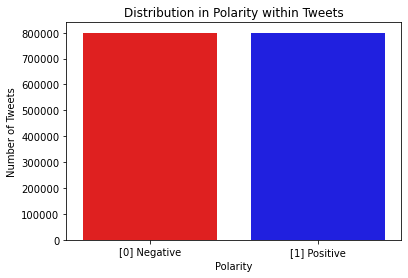

In [4]:
# Change [4] to [1] so the data is easier to understand.
df['polarity'] = df['polarity'].replace(4,1)

# Visualize whether data is evenly divided in terms of the polarity of tweets.
ax = sns.countplot(x="polarity", data=df, palette=['red', 'blue'])
ax.set_title('Distribution in Polarity within Tweets')
ax.set_xlabel('Polarity')
ax.set_xticks([0,1])
ax.set_xticklabels(['[0] Negative', '[1] Positive'])
ax.set_ylabel('Number of Tweets')

In [5]:
# Check for proper variable representations
# Make all tweets lowercase for future processing
df['tweet'] = df['tweet'].astype('str')
df['tweet'] = df['tweet'].str.lower()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   tweet     1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Text/Word Pre-processing

For this section I used some of the most common text-preprocessing that are practiced
in Natural Language Processing projects such as:     
- Removing stop words     
- Stemming words     
- Lemmatizing words
- Tokenizing individual words

In [6]:
import nltk
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

In [7]:
# ============ 1.) Removing HTML Tags, URLs, HashTags, Email Addresses, & tagged usernames with RegEx

# Parse through each of the tweets by using regular expressions to remove specific parts of the text
# RegEx Reference: https://github.com/alvations/nltk/blob/develop/nltk/tokenize/casual.py#L122
char_rm = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
hashtag, username=r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""", r"""(?:@[\w_]+)"""
emailAddr,htmlTags,=r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]""", r"""<[^>\s]+>"""
urls=r"""(?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:[a-z]{2,13})/)(?:[^\s()<>
    {}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]
    +\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:
    [.\-][a-z0-9]+)*[.](?:[a-z]{2,13})\b/?(?!@))"""

# Remove : hashtags, usernames, htmltags
df['tweet'] = df['tweet'].replace(urls, "" ,regex=True)
df['tweet'] = df['tweet'].replace(username, "" ,regex=True)
df['tweet'] = df['tweet'].replace(hashtag, "" ,regex=True)
df['tweet'] = df['tweet'].replace(htmlTags, "" ,regex=True)



# ============ 2.) Tokenizing words, removing stop words, changing words back to their stem word and lemmatizing words

# The following code was modeled after a snippet of code here:
# https://www.traindex.io/blog/event-driven-data-pipelines-in-aws-480i/
def preprocess(tweet, stem=False):
    # Remove link, user and special characters
    tweet = re.sub(char_rm, ' ', str(tweet)).strip()
    tweet_token = word_tokenize(tweet)
    tokens = []
    for token in tweet_token:
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in tokens:
        if len(w)>1:
            word = wordLemm.lemmatize(w)
            finalwords.append(word)
    return ' '.join(finalwords)


df['tweet'] = df['tweet'].apply(lambda x: preprocess(x))

df.head(20)

,polarity,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save 50 rest go b...
3,0,whole body feel itchy like fire
4,0,behaving mad see
5,0,whole crew
6,0,need hug
7,0,hey long time see yes rain bit bit lol fine th...
8,0,nope
9,0,que muera


For my final dataset that I will be using for my classification problem, in regards of
predicting whether a tweet is positive or negative, I selected to use only 2 columns:
- Polarity : Whether a tweet in negative or positive ([0] negative; [1] Positive;)
- Tweet : The text of a given tweet 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Choosing a Metric

As for metrics, for this specific classification problem, it is very easy to
know that I will be using accuracy as a metric to evaluate my algorithms's 
performance.It will use binary cross entropy as it's loss function given
the values of the polarity column are 0 and 1.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.4 Creating Training & Testing Data

In [8]:
# - Choose the method I'll use for dividing my data into training and testing (i.e., am I  using Stratified 10-fold cross validation? Shuffle splits? Why?).
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_TOP_WORDS = 1000 # only use top 1k words in vocabulary
MAX_REV_LEN = 50


tokenizer = Tokenizer(num_words=MAX_TOP_WORDS)
tokenizer.fit_on_texts(df.tweet)
sequences = tokenizer.texts_to_sequences(df.tweet)

word_index = tokenizer.word_index
MAX_TOP_WORDS = len(word_index) if MAX_TOP_WORDS==None else MAX_TOP_WORDS
top_words = min((len(word_index),MAX_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_REV_LEN)

y_ohe = keras.utils.to_categorical(df.polarity)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe,test_size=0.2,stratify=df['polarity'],random_state=42)

print("======= Train Shapes ======")
print('Train :', X_train.shape, '\nTest  :', y_train_ohe.shape)
print("\n====== Testing Shapes ======")
print('Train :', X_test.shape, '\nTest  :', y_test_ohe.shape)

Found 259546 unique tokens. Distilled to 1000 top words.
Shape of data tensor: (1600000, 50)
Shape of label tensor: (1600000, 2)
999
======= Train Shapes ======
Train : (1280000, 50) 
Test  : (1280000, 2)

====== Testing Shapes ======
Train : (320000, 50) 
Test  : (320000, 2)


- Explain why my chosen method is appropriate or use more than one method as appropriate.
- Convince me that my cross validation method is a realistic mirroring of how an algorithm would be used in practice.

-----------------------------

## 2. Modeling

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Exploring Recurrent Network Architectures

In [9]:
# Import Keras libraries

import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import average, Reshape, Input, Add, SimpleRNN
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GRU
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, LSTM
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Graph comparing Training & Validation Vs. Accuracy & Training loss
def getChart(h):
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(h.history['accuracy'])
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(h.history['val_accuracy'])
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    plt.plot(h.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(h.history['val_loss'])
    plt.xlabel('epochs')

# Graph comparing Training & Validation Vs. Accuracy & Training loss
def getCharts(h1, h2, h3, h4):
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    ax1 = sns.lineplot(data=h1.history['accuracy'], label='GRU - AdaM', color='blue')
    sns.lineplot(data=h2.history['accuracy'], label='GRU - RMSProp', color='red')
    sns.lineplot(data=h3.history['accuracy'], label='LSTM - AdaM', color='green')
    sns.lineplot(data=h4.history['accuracy'], label='LSTM - RMSProp ', color='darkorange')
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    ax2 = sns.lineplot(data=h1.history['val_accuracy'], label='GRU - AdaM', color='blue')
    sns.lineplot(data=h2.history['val_accuracy'], label='GRU - RMSProp', color='red')
    sns.lineplot(data=h3.history['val_accuracy'], label='LSTM - AdaM', color='green')
    sns.lineplot(data=h4.history['val_accuracy'], label='LSTM - RMSProp', color='darkorange')
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    ax3 = sns.lineplot(data=h1.history['loss'], label='GRU - AdaM', color='blue')
    sns.lineplot(data=h2.history['loss'], label='GRU - RMSProp', color='red')
    sns.lineplot(data=h3.history['loss'], label='LSTM - AdaM', color='green')
    sns.lineplot(data=h4.history['loss'], label='LSTM - RMSProp', color='darkorange')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    ax4 = sns.lineplot(data=h1.history['val_loss'], label='GRU - AdaM', color='blue')
    sns.lineplot(data=h2.history['val_loss'], label='GRU - RMSProp', color='red')
    sns.lineplot(data=h3.history['val_loss'], label='LSTM - AdaM', color='green')
    sns.lineplot(data=h4.history['val_loss'], label='LSTM - RMSProp', color='darkorange')
    plt.xlabel('epochs')

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.1 Method 1: GRU Architecture

A Gated Recurrent Network, or GRU
- Be sure to use an embedding layer (pre-trained, from scratch, OR both).
- Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [11]:
#################################################################################
######################## GRU Style Architecture : AdaM ##########################
#################################################################################
shpe = (MAX_REV_LEN,)
embed_Size = 50
rnn_StateSize = 100

rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
x1 = Embedding(MAX_TOP_WORDS,         # input dimension (max int of OHE)
               embed_Size,            # output dimension size
               input_length=MAX_REV_LEN)(input_holder) # number of words in each sequence

# create GRU
x1 = GRU(rnn_StateSize, dropout=0.2, recurrent_dropout=0.2)(x1)
x1 = Dense(2, activation='sigmoid')(x1)
gru_1 = Model(inputs=input_holder,outputs=x1)

print(gru_1.summary())

2023-06-03 21:18:18.849063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            50000     
                                                                 
 gru (GRU)                   (None, 100)               45600     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 95,802
Trainable params: 95,802
Non-trainable params: 0
_________________________________________________________________
None


2023-06-03 21:18:18.851727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 21:18:18.851999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 21:18:18.852628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 21:18:18.853264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/2
   5/2500 [..............................] - ETA: 1:33 - loss: 0.6930 - accuracy: 0.4926

2023-06-03 21:18:20.549831: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2500/2500 [==============================] - 98s 39ms/step - loss: 0.5162 - accuracy: 0.7403 - val_loss: 0.5041 - val_accuracy: 0.7480
Epoch 2/2
10000/10000 [==============================] - 78s 8ms/step
              precision    recall  f1-score   support

           0       0.77      0.71      0.74    160000
           1       0.73      0.79      0.76    160000

   micro avg       0.75      0.75      0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000
 samples avg       0.75      0.75      0.75    320000

CPU times: user 5min 24s, sys: 17.1 s, total: 5min 41s
Wall time: 4min 34s


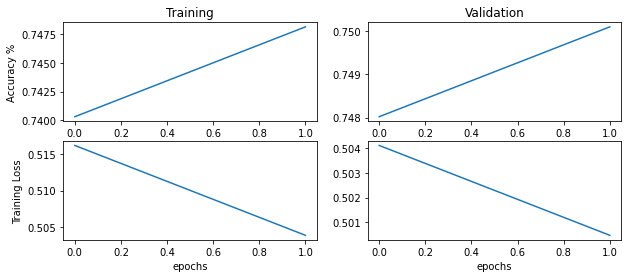

In [12]:
%%time

opt1 = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
gru_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_GRU1 = gru_1.fit(X_train, y_train_ohe, batch_size=512, 
                         epochs=2, verbose=1, validation_data=(X_test,y_test_ohe),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(gru_1.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_GRU1)

In [13]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [14]:
#################################################################################
######################## GRU Style Architecture : RMSProp #######################
#################################################################################

x2 = Embedding(MAX_TOP_WORDS,                  # input dimension (max int of OHE)
               embed_Size,                     # output dimension size
               input_length=MAX_REV_LEN)(input_holder) # number of words in each sequence


# create GRU
x2 = GRU(rnn_StateSize, dropout=0.2, recurrent_dropout=0.2)(x2)
x2 = Dense(2, activation='sigmoid')(x1)

gru_2 = Model(inputs=input_holder,outputs=x1)

print(gru_2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            50000     
                                                                 
 gru (GRU)                   (None, 100)               45600     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 95,802
Trainable params: 95,802
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/2
2500/2500 [==============================] - 98s 39ms/step - loss: 0.5008 - accuracy: 0.7503 - val_loss: 0.4974 - val_accuracy: 0.7527
Epoch 2/2
10000/10000 [==============================] - 79s 8ms/step
              precision    recall  f1-score   support

           0       0.77      0.72      0.75    160000
           1       0.74      0.79      0.76    160000

   micro avg       0.75      0.75      0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000
 samples avg       0.75      0.75      0.75    320000

CPU times: user 5min 26s, sys: 16.7 s, total: 5min 43s
Wall time: 4min 35s


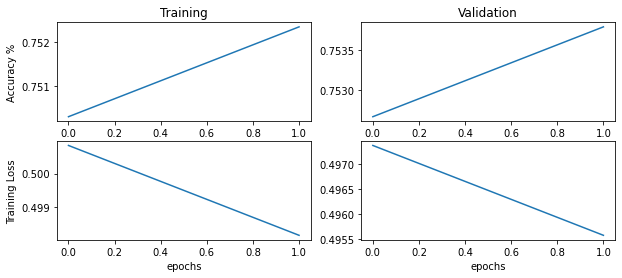

In [15]:
%%time

opt2 = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
gru_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_GRU2 = gru_2.fit(X_train, y_train_ohe, batch_size=512,
                         epochs=2, verbose=1, validation_data=(X_test,y_test_ohe),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(gru_2.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_GRU2)

In [16]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.2 Method 2: LSTM  Architecture

A "long short-term memory" units, or LSTM

In [17]:
###### Loading Glove
GLOVE_EMB = '../../glove.6B/glove.6B.300d.txt';
embed_Size = 300

embeddings_index = {}
f = open(GLOVE_EMB)
# save key/array pairs of the embeddings
#   the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#   keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, embed_Size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #  words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1
        
print("Embedding Shape:", embedding_matrix.shape, "\n",
      "Total words found:", found_words, "\n",
      "Percetage:", 100 * found_words / embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (259547, 300) 
 Total words found: 87569 
 Percetage: 33.73916862841797


In [18]:
##################################################################################
######################## LSTM Style Architecture : AdaM ##########################
##################################################################################
shpe = (MAX_REV_LEN,)
l2_lambda = 0.000001

input_holder = Input(shape=shpe, dtype='int32')

# Embedding Layer ================================================================
x3 = Embedding(len(word_index) + 1,          # input dimension (max int of OHE)
               embed_Size,                   # output dimension size
               weights=[embedding_matrix],
               input_length=MAX_TOP_WORDS,   # number of words in each sequence
               trainable=False)(input_holder)

# Spatial Dropout Layer ==========================================================
x3 = SpatialDropout1D(0.2)(x3)
x3 = Activation('relu')(x3)

# Convolution Layer ==============================================================
x3 = Conv1D(64,5)(x3)

# Bidirectional Layer ============================================================
x3 = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x3)
x3 = Activation('relu')(x3)
x3 = Dense(512)(x3)
x3 = Dropout(0.5)(x3)

x3 = Activation('relu')(x3)
x3 = Dropout(0.5)(x3)

x3 = Activation('relu')(x3)
x3 = Dense(512)(x3)

x3 = Activation('sigmoid')(x3)
x3 = Dense(1)(x3)

lstm_1 = Model(inputs=input_holder,outputs=x3)

In [ ]:
%%time

lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_LSTM1 = lstm_1.fit(X_train, y_train_ohe, batch_size=512,
                           epochs=2, verbose=1, validation_data=(X_test,y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(lstm_1.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_LSTM1)

In [20]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [ ]:
##################################################################################
######################## LSTM Style Architecture : RMSProp #######################
##################################################################################


# - Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# - The input to the second chain should be the output sequence of the first chain.
   
# Embedding Layer ================================================================
x4 = Embedding(input_dim=MAX_TOP_WORDS,         # input dimension (max int of OHE)
               output_dim=embed_Size,
               input_length=MAX_REV_LEN,        # number of words in each sequence
               weights=[embedding_matrix],
               trainable=False)(x4)

# Bidirectional Layer ============================================================ 
x4 = Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
x4 = Dropout(0.3),


# Bidirectional Layer ============================================================ 
x4 = Bidirectional(LSTM(64,dropout=0.3))(x4)
x4 = Dropout(0.3)(x4)

x4 = Activation("relu")(x4)
x4 = Dense(512)(x4)
x4 = Dropout(0.3)(x4)
                  
x4 = Activation("sigmoid")(x4)
x4 = Dense(1)(x4)

In [ ]:
##################################################################################
######################## LSTM Style Architecture : RMSProp #######################
##################################################################################


# - Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# - The input to the second chain should be the output sequence of the first chain.
   
# Embedding Layer ================================================================
x4 = Embedding(input_dim=MAX_TOP_WORDS,          # input dimension (max int of OHE)
               output_dim=embed_Size,
               input_length=MAX_REV_LEN,         # number of words in each sequence
               weights=[embedding_matrix],
               trainable=False)(x4)

# Bidirectional Layer ============================================================ 
x4 = Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
x4 = Dropout(0.3),


# Bidirectional Layer ============================================================ 
x4 = Bidirectional(LSTM(64,dropout=0.3))(x4)
x4 = Dropout(0.3)(x4)

x4 = Activation("relu")(x4)
x4 = Dense(512)(x4)
x4 = Dropout(0.3)(x4)
                  
x4 = Activation("sigmoid")(x4)
x4 = Dense(1)(x4)

In [ ]:
%%time

lstm_2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history_LSTM2 = lstm_2.fit(X_train, y_train_ohe, batch_size=512,
                           epochs=2, verbose=1, validation_data=(X_test,y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(lstm_2.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_LSTM2)

In [ ]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

- Discuss the performance of each network & compare them.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Adding a 2nd recurrent chain

In [ ]:

# Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# The input to the second chain should be the output sequence of the first chain.
# Visualize the performance of training & validation sets versus the training iterations.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Using Cross Validation

In [ ]:

# - Use the method of cross validation & evaluation criteria that I argued for at the beginning of the lab.


In [ ]:

# - Visualize the results of all the RNNs I trained.


In [ ]:

# Use proper statistical comparison techniques to determine which method(s) is (are) superior.


----------------------------------------

### 3. t-SNE or RNN generating novel text
You have free reign to provide additional analyses. Ideas:

- Option 1: Use t-SNE (or SVD or PCA or UMAP) to visualize the word embeddings of a subset of words in your vocabulary.
    - Try to interpret what each dimension reflects (in your own words).
    - That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding.

- Options 2: Use the ConceptNet Numberbatch embedding & compare to GloVe

- Another Idea (NOT required): Try to create a RNN for generating novel text.